In [174]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import sys

In [56]:
dims = 2
dx = 1
minx = 0
maxx = 100

def isvalid(x):
    R = 15**2
    valid = np.sum((np.array(x)-50)**2)<R
    return valid

def inspace(x):
    for xd in x:
        if xd<minx or xd>maxx:
            return False
    return True
        

In [4]:
def explore_dim(dim,dx,valid_solns,computed_solns):
    valid_solns0 = set(valid_solns)
    for v in valid_solns0:
        xm = list(v)
        xm[dim] -= dx
        xm = tuple(xm)
        xp = list(v)
        xp[dim] += dx
        xp = tuple(xp)
        xes = [xm,xp]
        for x in xes:
            if inspace(x):
                if x not in computed_solns:
                    computed_solns.add(x)
                    if isvalid(x):
                        valid_solns.add(x)
                        explore_dim(dim,dx,valid_solns,computed_solns)


In [5]:
def explore_both(dx,valid_solns,computed_solns):
    valid_solns1 = set(valid_solns)
    computed_solns1 = set(computed_solns)
    valid_solns2 = set(valid_solns)
    computed_solns2 = set(computed_solns)
    explore_dim(0,dx,valid_solns1,computed_solns1)
    explore_dim(1,dx,valid_solns2,computed_solns2)
    valid_solns.update(valid_solns1,valid_solns2)
    computed_solns.update(computed_solns1,computed_solns2)

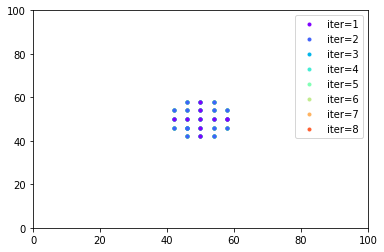

In [6]:
valid_solns = {(50,50)}
computed_solns = set(valid_solns)
dx = 4
N = 8
for i in range(N):
    explore_both(dx,valid_solns,computed_solns)
    for x in valid_solns:
        plt.plot(x[0],x[1],'.',color=plt.cm.rainbow(i/N),zorder=1/(i+1))
    plt.plot(x[0],x[1],'.',color=plt.cm.rainbow(i/N),zorder=1/(i+1),label='iter={}'.format(i+1))

plt.xlim(minx,maxx)
plt.ylim(minx,maxx)
plt.legend()

# Multiprocessing

In [111]:
from multiprocessing import Process, Queue

In [162]:
def explore_pos(x,dim,dx,valid_solns,computed_solns):
    xp = list(x)
    xp[dim] += dx
    xp = tuple(xp)
    if not inspace(xp):
        return
    if xp in computed_solns:
        return
    computed_solns.add(xp)
    if not isvalid(xp):
        return
    valid_solns.add(xp)
    explore_pos(xp,dim,dx,valid_solns,computed_solns)

def explore_neg(x,dim,dx,valid_solns,computed_solns):
    xm = list(x)
    xm[dim] -= dx
    xm = tuple(xm)
    if not inspace(xm):
        return
    if xm in computed_solns:
        return
    computed_solns.add(xm)
    if not isvalid(xm):
        return
    valid_solns.add(xm)
    explore_neg(xm,dim,dx,valid_solns,computed_solns)

def explore_dim(dim,dx,valid_solns,computed_solns):
    valid_solns0 = set(valid_solns)
    for v in valid_solns0:
        explore_pos(v,dim,dx,valid_solns,computed_solns)
    for v in valid_solns0:
        explore_neg(v,dim,dx,valid_solns,computed_solns)

def multi_explore(dim,dx,valid_solns,computed_solns, q):
    explore_dim(dim,dx,valid_solns,computed_solns)
    q.put([valid_solns,computed_solns])

def run_parallel(dims, dxs, valid_solns, computed_solns):
    qs = []
    ps = []
    for dim in dims:
        qs.append(Queue())
        ps.append(Process(target=multi_explore, args=(dim,dxs[dim],valid_solns,computed_solns,qs[dim])))
        ps[dim].start()
    for dim in dims:
        out = qs[dim].get()    # prints "[42, None, 'hello']"
        valid_solns.update(out[0])
        computed_solns.update(out[1])
        ps[dim].join()

def iter_parallel(dims,dxs,valid_solns,computed_solns, Nmax):
    N = 0
    done = False
    while(not done and N<Nmax):
        N +=1
        Ncomp = len(computed_solns)
        run_parallel(dims,dxs,valid_solns,computed_solns)
        if Ncomp == len(computed_solns):
            done=True
    print('done after {} iters'.format(N))
    print(len(valid_solns),len(computed_solns))
    return valid_solns,computed_solns

In [170]:
dims = 2
dx = 1
minx = 0
maxx = 100

def isvalid(x):
    R = 2**2
    valid = np.sum((np.array(x)-50)**2)<R
    return valid

def inspace(x):
    for xd in x:
        if xd<minx or xd>maxx:
            return False
    return True
        

In [172]:
Ndim = 6
valid_solns = {tuple([50]*Ndim)}
computed_solns = set(valid_solns)
dims = list(range(Ndim))
dxs = tuple([1]*Ndim)

Nmax = 10
vout, cout = iter_parallel(dims, dxs, valid_solns, computed_solns, Nmax)

done after 5 iters
233 1085


In [173]:
valid_solns

{(49, 49, 49, 50, 50, 50),
 (49, 49, 50, 49, 50, 50),
 (49, 49, 50, 50, 49, 50),
 (49, 49, 50, 50, 50, 49),
 (49, 49, 50, 50, 50, 50),
 (49, 49, 50, 50, 50, 51),
 (49, 49, 50, 50, 51, 50),
 (49, 49, 50, 51, 50, 50),
 (49, 49, 51, 50, 50, 50),
 (49, 50, 49, 49, 50, 50),
 (49, 50, 49, 50, 49, 50),
 (49, 50, 49, 50, 50, 49),
 (49, 50, 49, 50, 50, 50),
 (49, 50, 49, 50, 50, 51),
 (49, 50, 49, 50, 51, 50),
 (49, 50, 49, 51, 50, 50),
 (49, 50, 50, 49, 49, 50),
 (49, 50, 50, 49, 50, 49),
 (49, 50, 50, 49, 50, 50),
 (49, 50, 50, 49, 50, 51),
 (49, 50, 50, 49, 51, 50),
 (49, 50, 50, 50, 49, 49),
 (49, 50, 50, 50, 49, 50),
 (49, 50, 50, 50, 49, 51),
 (49, 50, 50, 50, 50, 49),
 (49, 50, 50, 50, 50, 50),
 (49, 50, 50, 50, 50, 51),
 (49, 50, 50, 50, 51, 49),
 (49, 50, 50, 50, 51, 50),
 (49, 50, 50, 50, 51, 51),
 (49, 50, 50, 51, 49, 50),
 (49, 50, 50, 51, 50, 49),
 (49, 50, 50, 51, 50, 50),
 (49, 50, 50, 51, 50, 51),
 (49, 50, 50, 51, 51, 50),
 (49, 50, 51, 49, 50, 50),
 (49, 50, 51, 50, 49, 50),
 

# Testing

In [149]:
Ndim = 1
valid_solns = {tuple([50]),tuple([54])}
computed_solns = set(valid_solns)
explore_pos(tuple([54]*Ndim),0,2,valid_solns,computed_solns)
print(computed_solns)
print(valid_solns)

{(58,), (64,), (54,), (60,), (66,), (62,), (50,), (56,)}
{(58,), (64,), (54,), (60,), (62,), (50,), (56,)}
